# Read Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics

#Light GBM
from fastai.tabular import * 

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

PATH = '/media/maria/2TB Monster driv/PrecisionFDA/'
PATH_COVID = '/media/maria/2TB Monster driv/PrecisionFDA/NeuralNetwork/COVID/'

In [2]:
from fastai.callbacks import *

# Read Data

In [3]:
train = pd.read_csv(PATH + 'Descriptive/train.csv')
test = pd.read_csv(PATH + 'Descriptive/test.csv')

In [4]:
nocovid  = pd.read_csv(PATH_COVID + 'no_covid_predicted.csv')

In [5]:
train = train.loc[train.COVID_Status == 1]
train.shape

(73697, 945)

In [6]:
oof_df = train[["Id", "Days_hospitalized"]]

In [7]:
train.shape

(73697, 945)

In [8]:
train.drop(columns=['Death', 'Hospitalized', 'Ventilator', 'ICU', 'Id', 'COVID_Status', 
                    'Days_ICU', 'Death Certification'], inplace=True)  

In [9]:
#Display all database

def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [10]:
display_all(train.describe())

DRIVERS  PASSPORT           LAT           LON  HEALTHCARE_EXPENSES  \
count  73697.0   73697.0  73697.000000  73697.000000         7.369700e+04   
mean       1.0       1.0     42.276641    -71.355158         9.958533e+05   
std        0.0       0.0      0.280952      0.594560         5.257319e+05   
min        1.0       1.0     41.241591    -73.490615         4.391440e+03   
25%        1.0       1.0     42.126691    -71.537896         6.186478e+05   
50%        1.0       1.0     42.316542    -71.153067         1.078231e+06   
75%        1.0       1.0     42.455546    -71.022418         1.440909e+06   
max        1.0       1.0     42.900027    -69.921561         3.203008e+06   

       HEALTHCARE_COVERAGE           Age  Allergy to bee venom  \
count         7.369700e+04  73697.000000           7545.000000   
mean          2.272775e+04     53.953974              0.190192   
std           5.957766e+04     18.640218              0.392479   
min           0.000000e+00     21.000000              0.000000   
25%           5.048600e+03     38.000000              0.000000   
50%           8.902250e+03     55.000000              0.000000   
75%           1.581682e+04     70.000000              0.000000   
max           1.557373e+06     84.000000              1.000000   

       Allergy to dairy product  Allergy to eggs  Allergy to fish  \
count               7545.000000      7545.000000      7545.000000   
mean                   0.038436         0.046918         0.183035   
std                    0.192259         0.211478         0.386721   
min                    0.000000         0.000000         0.000000   
25%                    0.000000         0.000000         0.000000   
50%                    0.000000         0.000000         0.000000   
75%                    0.000000         0.000000         0.000000   
max                    1.000000         1.000000         1.000000   

       Allergy to grass pollen  Allergy to mould  Allergy to nut  \
count              7545.000000       7545.000000     7545.000000   
mean                  0.278330          0.381975        0.180517   
std                   0.448206          0.485903        0.384643   
min                   0.000000          0.000000        0.000000   
25%                   0.000000          0.000000        0.000000   
50%                   0.000000          0.000000        0.000000   
75%                   1.000000          1.000000        0.000000   
max                   1.000000          1.000000        1.000000   

       Allergy to peanuts  Allergy to soya  Allergy to tree pollen  \
count         7545.000000      7545.000000             7545.000000   
mean             0.196024         0.017097                0.271040   
std              0.397013         0.129643                0.444526   
min              0.000000         0.000000                0.000000   
25%              0.000000         0.000000                0.000000   
50%              0.000000         0.000000                0.000000   
75%              0.000000         0.000000                1.000000   
max              1.000000         1.000000                1.000000   

       Allergy to wheat  Dander (animal) allergy  House dust mite allergy  \
count       7545.000000              7545.000000              7545.000000   
mean           0.043738                 0.353612                 0.268257   
std            0.204524                 0.478122                 0.443082   
min            0.000000                 0.000000                 0.000000   
25%            0.000000                 0.000000                 0.000000   
50%            0.000000                 0.000000                 0.000000   
75%            0.000000                 1.000000                 1.000000   
max            1.000000                 1.000000                 1.000000   

       Latex allergy  Shellfish allergy  Agreeing on diabetes care plan  \
count    7545.000000        7545.000000                    67162.000000   
mean    

# Training Neural Network 

In [11]:
procs = [FillMissing, Categorify, Normalize]

In [12]:
dep_var = 'Days_hospitalized'
cat_names = ['DRIVERS' , 'PASSPORT', 'MARITAL', 'RACE', 'ETHNICITY',
             'GENDER', 'COUNTY', 'PLACE_BIRTH']

In [13]:
PATH_data = PATH + 'Descriptive/'

In [14]:
# Setting random seed

SEED = 2019

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    #tf.set_random_seed(seed)
seed_everything(SEED)


In [15]:
len(test)

29492

In [16]:
#5 Fold cross-validation
nfold = 5
target = 'Days_hospitalized'
skf = KFold(n_splits=nfold, shuffle=True, random_state=2019)

oof = np.zeros(len(train))
predictions = np.zeros(len(test))

In [17]:
train['Days_hospitalized'] = train['Days_hospitalized'].fillna(0)

In [18]:
train['Days_hospitalized'].describe()

count    73697.000000
mean         3.493102
std          6.217843
min          0.000000
25%          0.000000
50%          0.000000
75%          5.147222
max         21.498611
Name: Days_hospitalized, dtype: float64

In [19]:
dep_var

'Days_hospitalized'


fold 1


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


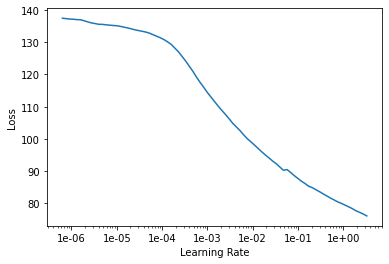

In [20]:
#Find Learning Rate
i = 1
cont_names = list(set(train)-set(cat_names)-{dep_var})

for train_index, valid_idx in skf.split(train, train.Days_hospitalized.values):
    if i>1: 
        break
    print("\nfold {}".format(i))
    
    data= (TabularList.from_df(train, path=PATH_data, cat_names=cat_names, 
                               cont_names = cont_names, procs=procs)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList)
                .databunch(bs=4096))
    
    learn = tabular_learner(data, layers=[3600, 1800], emb_drop=0.05, 
                            metrics=[root_mean_squared_error], y_range=(0, 21.5 * 1.2)) 
    #learn.loss_fn 
    
    learn.lr_find()
    learn.recorder.plot()
    i=i+1


In [21]:
learn.loss_func

FlattenedLoss of MSELoss()

In [22]:
test.shape

(29492, 938)

In [23]:
#Metric 
#root_mean_squared_error
#rms = sqrt(mean_squared_error(train.Days_hospitalized.values, oof))

In [24]:
i = 1
lr = 1e-2

for train_index, valid_idx in skf.split(train, train.Days_hospitalized.values):
    print("\nfold {}".format(i))
    
    
    data= (TabularList.from_df(train, path=PATH_data, cat_names=cat_names, cont_names = cont_names, procs=procs)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList)
                .add_test(TabularList.from_df(test, path=PATH_data, cat_names=cat_names, cont_names = cont_names))
                .databunch(bs=4096))
    
    
    learn = tabular_learner(data, layers=[3600, 1800], emb_drop=0.05, 
                            metrics=[root_mean_squared_error],
                           y_range=(0, 21.5 * 1.2)) 
    
    learn.fit_one_cycle(15, slice(lr), callbacks=[SaveModelCallback(learn, every='improvement',
                                              monitor='valid_loss', name='bestmodel_hospitalized_fold{}'.format(i))], wd=0.1)
    learn.load('bestmodel_hospitalized_fold{}'.format(i))
    interp = ClassificationInterpretation.from_learner(learn)


    preds_valid = learn.get_preds(ds_type=DatasetType.Valid)
    predictions_v = []

    for j in range(len(valid_idx)):
        predictions_v.append(float(preds_valid[0][j].cpu().numpy()))
    
    oof[valid_idx] = predictions_v 
    
    preds = learn.get_preds(ds_type=DatasetType.Test)
    
    predictions_t = []

    for j in range(test.shape[0]):
        predictions_t.append(float(preds[0][j].cpu().numpy()))

    #print(predictions_t)
    predictions += predictions_t 
    i = i + 1


fold 1


epoch,train_loss,valid_loss,root_mean_squared_error,time
0,106.790779,80.524712,8.973186,00:05
1,86.133392,74.908516,8.654761,00:05
2,73.422279,65.578941,8.097759,00:05
3,64.579689,50.774063,7.125123,00:05
4,58.943974,48.568539,6.968723,00:05
5,55.207916,46.954937,6.852079,00:05
6,52.663963,47.766399,6.910975,00:05
7,50.916706,46.874516,6.846179,00:05
8,49.587715,46.636574,6.828804,00:05
9,48.562820,46.684380,6.832347,00:05


Better model found at epoch 0 with valid_loss value: 80.52471160888672.
Better model found at epoch 1 with valid_loss value: 74.90851593017578.
Better model found at epoch 2 with valid_loss value: 65.57894134521484.
Better model found at epoch 3 with valid_loss value: 50.77406311035156.
Better model found at epoch 4 with valid_loss value: 48.568538665771484.
Better model found at epoch 5 with valid_loss value: 46.95493698120117.
Better model found at epoch 7 with valid_loss value: 46.874515533447266.
Better model found at epoch 8 with valid_loss value: 46.636573791503906.



fold 2


epoch,train_loss,valid_loss,root_mean_squared_error,time
0,134.823044,325.334900,18.036823,00:05
1,99.492477,323.010132,17.972097,00:05
2,81.822357,278.327057,16.682905,00:05
3,71.988129,85.140190,9.227107,00:05
4,65.339157,160.397705,12.664453,00:05
5,60.081333,49.401058,7.028389,00:05
6,56.366158,49.097580,7.006718,00:05
7,53.666759,47.441792,6.887447,00:05
8,51.624371,47.484200,6.890654,00:05
9,50.100006,47.190418,6.869230,00:05


Better model found at epoch 0 with valid_loss value: 325.33489990234375.
Better model found at epoch 1 with valid_loss value: 323.0101318359375.
Better model found at epoch 2 with valid_loss value: 278.3270568847656.
Better model found at epoch 3 with valid_loss value: 85.14019012451172.
Better model found at epoch 5 with valid_loss value: 49.401058197021484.
Better model found at epoch 6 with valid_loss value: 49.09757995605469.
Better model found at epoch 7 with valid_loss value: 47.44179153442383.
Better model found at epoch 9 with valid_loss value: 47.1904182434082.



fold 3


epoch,train_loss,valid_loss,root_mean_squared_error,time
0,120.025085,109.927841,10.484487,00:05
1,92.747185,72.575157,8.518392,00:05
2,79.641083,61.711014,7.854896,00:05
3,69.856934,50.485100,7.104054,00:05
4,62.763985,48.132278,6.936433,00:05
5,58.446590,48.427990,6.957645,00:05
6,55.543030,52.946217,7.274858,00:05
7,53.038532,46.649990,6.828644,00:05
8,51.139091,46.291668,6.802214,00:05
9,49.733974,46.243732,6.798850,00:05


Better model found at epoch 0 with valid_loss value: 109.92784118652344.
Better model found at epoch 1 with valid_loss value: 72.57515716552734.
Better model found at epoch 2 with valid_loss value: 61.71101379394531.
Better model found at epoch 3 with valid_loss value: 50.48509979248047.
Better model found at epoch 4 with valid_loss value: 48.13227844238281.
Better model found at epoch 7 with valid_loss value: 46.64999008178711.
Better model found at epoch 8 with valid_loss value: 46.29166793823242.
Better model found at epoch 9 with valid_loss value: 46.24373245239258.



fold 4


epoch,train_loss,valid_loss,root_mean_squared_error,time
0,118.884148,92.386559,9.611590,00:05
1,90.838211,70.633781,8.404368,00:05
2,76.861809,418.279541,20.451632,00:05
3,64.937607,294.319641,17.155161,00:05
4,56.579586,46.086750,6.787663,00:05
5,51.244415,42.310112,6.503908,00:05
6,47.736137,40.292423,6.346886,00:05
7,45.113197,41.083321,6.408985,00:05
8,43.177265,38.485645,6.203391,00:05
9,41.767384,37.968365,6.161456,00:05


Better model found at epoch 0 with valid_loss value: 92.38655853271484.
Better model found at epoch 1 with valid_loss value: 70.63378143310547.
Better model found at epoch 4 with valid_loss value: 46.08675003051758.
Better model found at epoch 5 with valid_loss value: 42.31011199951172.
Better model found at epoch 6 with valid_loss value: 40.292423248291016.
Better model found at epoch 8 with valid_loss value: 38.48564529418945.
Better model found at epoch 9 with valid_loss value: 37.96836471557617.
Better model found at epoch 11 with valid_loss value: 37.871116638183594.



fold 5


epoch,train_loss,valid_loss,root_mean_squared_error,time
0,107.137558,85.665253,9.254912,00:05
1,87.121262,67.966591,8.243018,00:05
2,75.416481,321.700043,17.935944,00:05
3,64.088753,398.377899,19.959366,00:05
4,56.080708,129.886520,11.396731,00:05
5,50.836624,44.052334,6.636672,00:05
6,47.351601,40.380157,6.353851,00:05
7,44.825726,40.972023,6.400519,00:05
8,42.953808,39.368206,6.274054,00:05
9,41.526192,38.984200,6.243314,00:05


Better model found at epoch 0 with valid_loss value: 85.66525268554688.
Better model found at epoch 1 with valid_loss value: 67.96659088134766.
Better model found at epoch 5 with valid_loss value: 44.05233383178711.
Better model found at epoch 6 with valid_loss value: 40.380157470703125.
Better model found at epoch 8 with valid_loss value: 39.36820602416992.
Better model found at epoch 9 with valid_loss value: 38.98419952392578.
Better model found at epoch 10 with valid_loss value: 38.774314880371094.
Better model found at epoch 13 with valid_loss value: 38.75926971435547.


# Explanations

In [25]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(train.Days_hospitalized.values, oof))

In [26]:
rms

6.5833365570128395

In [27]:
pred = oof

In [28]:
#code from https://forums.fast.ai/t/feature-importance-in-deep-learning/42026/6
def feature_importance(learner, cat_names, cont_names): 
  # based on: https://medium.com/@mp.music93/neural-networks-feature-importance-with-fastai-5c393cf65815
    loss0=np.array([learner.loss_func(learner.pred_batch(batch=(x,y.to("cpu"))), y.to("cpu")) for x,y in iter(learner.data.valid_dl)]).mean()
    fi=dict()
    types=[cat_names, cont_names]
    for j, t in enumerate(types):
        for i, c in enumerate(t):
            loss=[]
            for x,y in iter(learner.data.valid_dl):
                col=x[j][:,i]    #x[0] da hier cat-vars
                idx = torch.randperm(col.nelement())
                x[j][:,i] = col.view(-1)[idx].view(col.size())
                y=y.to('cpu')
                loss.append(learner.loss_func(learner.pred_batch(batch=(x,y)), y))
            fi[c]=np.array(loss).mean()-loss0
    d = sorted(fi.items(), key=lambda kv: kv[1], reverse=True)
    return pd.DataFrame({'cols': [l for l, v in d], 'imp': np.log1p([v for l, v in d])})

In [29]:
imp = feature_importance(learn, cat_names, cont_names)

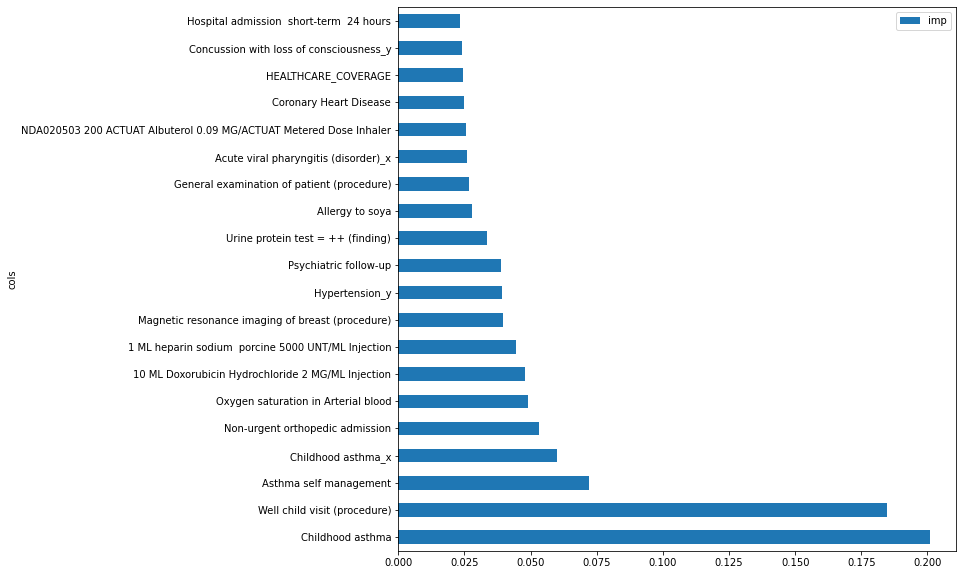

In [30]:
imp[:20].plot.barh(x="cols", y="imp", figsize=(10, 10))

In [31]:
nocovid["COVID_flag"] = 0

In [32]:
sub_df = pd.DataFrame({'Id':test['Id'], 'Hospitalized': predictions/nfold})


In [33]:
sub_df = sub_df.merge(nocovid, how='left', left_on ='Id', right_on ='Id')
sub_df['COVID_flag'] = sub_df['COVID_flag'].fillna(1)

In [34]:
sub_df["Hospitalized"] = sub_df["Hospitalized"] * sub_df['COVID_flag']

In [35]:
sub_df[['Id', 'Hospitalized']].to_csv("NN_Hospitalized_5Fold.csv", index=False, line_terminator='\n', header=False)

In [36]:
np.mean(sub_df["Hospitalized"]/5)

0.5413153745898875

In [37]:
sub_df[:10]

,Id,Hospitalized,COVID_flag
0,8c6f61a6-1beb-4b51-980e-381722ca7e33,0.000000,0.0
1,6732e6fc-f8f3-4b1a-924a-47f68f19526c,2.924220,1.0
2,4772a573-1fb1-49ec-be86-dc2c4b176052,2.470996,1.0
3,edb75aa7-7b67-48ce-9990-0095cd7a3b8d,0.000000,0.0
4,e28f36cd-c8d8-4c64-94e7-91c89d1be9d1,4.065278,1.0
5,91f07bd7-2b45-4c52-9f7b-a855e130c9c6,2.191388,1.0
6,8f750c87-91aa-46a6-907c-d56b11ddc62b,0.000000,0.0
7,b08fac91-3d10-4b4d-b4f0-a4c5c72094b1,0.000000,0.0
8,e31d9eec-b088-465c-81fd-dd3593e8c29f,3.668715,1.0
9,e21e899d-f3d7-4c98-a66d-145a542c092b,0.000000,0.0
